# APPLY RATE ANALYSIS

In [1]:
import pandas as pd
import sys
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, precision_recall_curve,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PolynomialFeatures

In [2]:
df=pd.read_csv("Datasets/Apply_Rate_2019.csv")

In [3]:
df.city_match=df.city_match.astype('category')
df['apply']=df['apply'].astype('category')
df.class_id=df.class_id.astype('category')

In [4]:
print("Number of searches by day")
pd.DataFrame(df.groupby('search_date_pacific')['apply'].count())

Number of searches by day


,apply
search_date_pacific,
2018-01-21,168163
2018-01-22,16016
2018-01-23,242371
2018-01-24,250276
2018-01-25,229836
2018-01-26,177702
2018-01-27,116526


In [5]:
for i in df.search_date_pacific.unique():
    print (i+" : "+str(df[df.search_date_pacific==i].isnull().sum().sum()))

2018-01-21 : 106479
2018-01-23 : 152012
2018-01-24 : 159180
2018-01-25 : 146008
2018-01-26 : 112496
2018-01-27 : 76122
2018-01-22 : 9400


In [6]:
print("Total count for classes city match 0 and city match 1")
pd.DataFrame(df.city_match.value_counts())

Total count for classes city match 0 and city match 1


,city_match
1.0,532299
0.0,412036


In [7]:
print("Total count for classes apply 0 and apply 1")
pd.DataFrame(df['apply'].value_counts())

Total count for classes apply 0 and apply 1


,apply
0,1092887
1,108003


In [8]:
print("Top 5 class id have these many rows: ")
pd.DataFrame(df.class_id.value_counts().head())

Top 5 class id have these many rows: 


,class_id
8530323770842619191,75586
-4246715430060585348,45489
-6998215076096305299,35263
-1614082818015232436,32449
3519666681604228547,30502


In [9]:
print("Bottom 5 class id have these many rows: ")
pd.DataFrame(df.class_id.value_counts().tail())

Bottom 5 class id have these many rows: 


,class_id
1195981532243725337,390
184216802986074299,363
-8850268828492112939,320
-552876871558262605,314
4271929576818699133,237


### Analysis of Top 5 class_id

In [10]:
for i in  df.class_id.value_counts().head().index.tolist():
    print("for class id :"+str(i))
    vc=df[df.class_id==i]['apply'].value_counts()
    print(str(pd.DataFrame(vc)))
    print("Apply Rate = "+str(vc[1]/(vc[0]+vc[1]))+"\n")

for class id :8530323770842619191
   apply
0  65289
1  10297
Apply Rate = 0.13622893128357103

for class id :-4246715430060585348
   apply
0  41124
1   4365
Apply Rate = 0.09595726439358966

for class id :-6998215076096305299
   apply
0  31751
1   3512
Apply Rate = 0.09959447579616028

for class id :-1614082818015232436
   apply
0  30109
1   2340
Apply Rate = 0.07211316219297975

for class id :3519666681604228547
   apply
0  26430
1   4072
Apply Rate = 0.13349944265949773



To get an idea how the missing values are distributed in the data set 

252571 missing values in -> title_proximity_tfidf  of type  float64
252571 missing values in -> description_proximity_tfidf  of type  float64
256555 missing values in -> city_match  of type  category


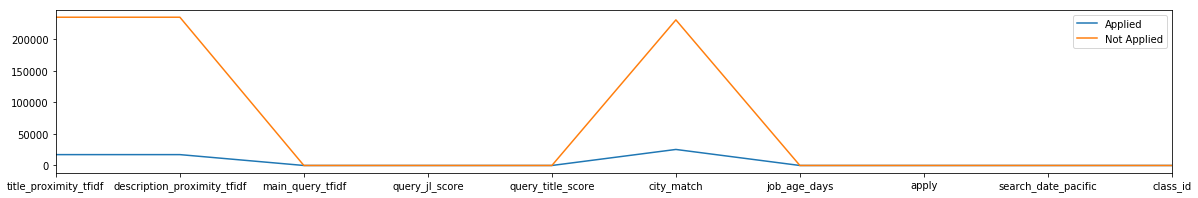

In [11]:
print("To get an idea how the missing values are distributed in the data set \n")
col=0
for i in df.isnull().sum():
    if i>0:
        print(i,"missing values in ->",df.columns[col]," of type ",df.dtypes[col])
    col=col+1
plt.figure(num=None, figsize=(20,3)) 
df[df['apply']==1].isnull().sum().plot()
df[df['apply']==0].isnull().sum().plot().legend(["Applied","Not Applied"])

plt.show()

**Discoveries about the data:**

- Correlation matrix showed some correlation between features main_query_tfidf and title_proximity_tfidf
- class_id had 157 different values and uneven distribution
- apply 1 is less than 10% of apply 0 i.e. High class imbalance 
- 20% values were missing for title_proximity_tfidf,description_proximity_tfidf,city_match


### Impute Missing Values

In [12]:
def Impute_Values(df_imp,option):
    for i in df_imp.columns[df_imp.isnull().any()]:
        if str(df_imp[i].dtype)=="category":
            df_imp[i]=df_imp[i].fillna(0)
            continue
        if option == 1:
            df_imp[i]=df_imp[i].fillna(df_imp[i].min())
        
        elif option == 2:
            df_imp[i]=df_imp[i].fillna(df_imp[i].mean())
          
        elif option == 3:
            df_imp[i]=df_imp[i].fillna(df_imp[i].median())
     
        elif option ==4:
            df_imp[i]=df_imp[i].fillna(df_imp[i].max())
        

In [13]:
#Choose Mean as imputation technique
Impute_Values(df,2)
#Drop Duplicates
df=df.drop_duplicates()

In [14]:
scaler = MinMaxScaler()
df[df.columns[:-3]] = scaler.fit_transform(df[df.columns[:-3]])

### Test Train Split

In [15]:
df_test=df[df['search_date_pacific']>'2018-01-26']
df_train=df.drop(df_test.index)

### Feature Analysis

<Figure size 4800x4800 with 0 Axes>

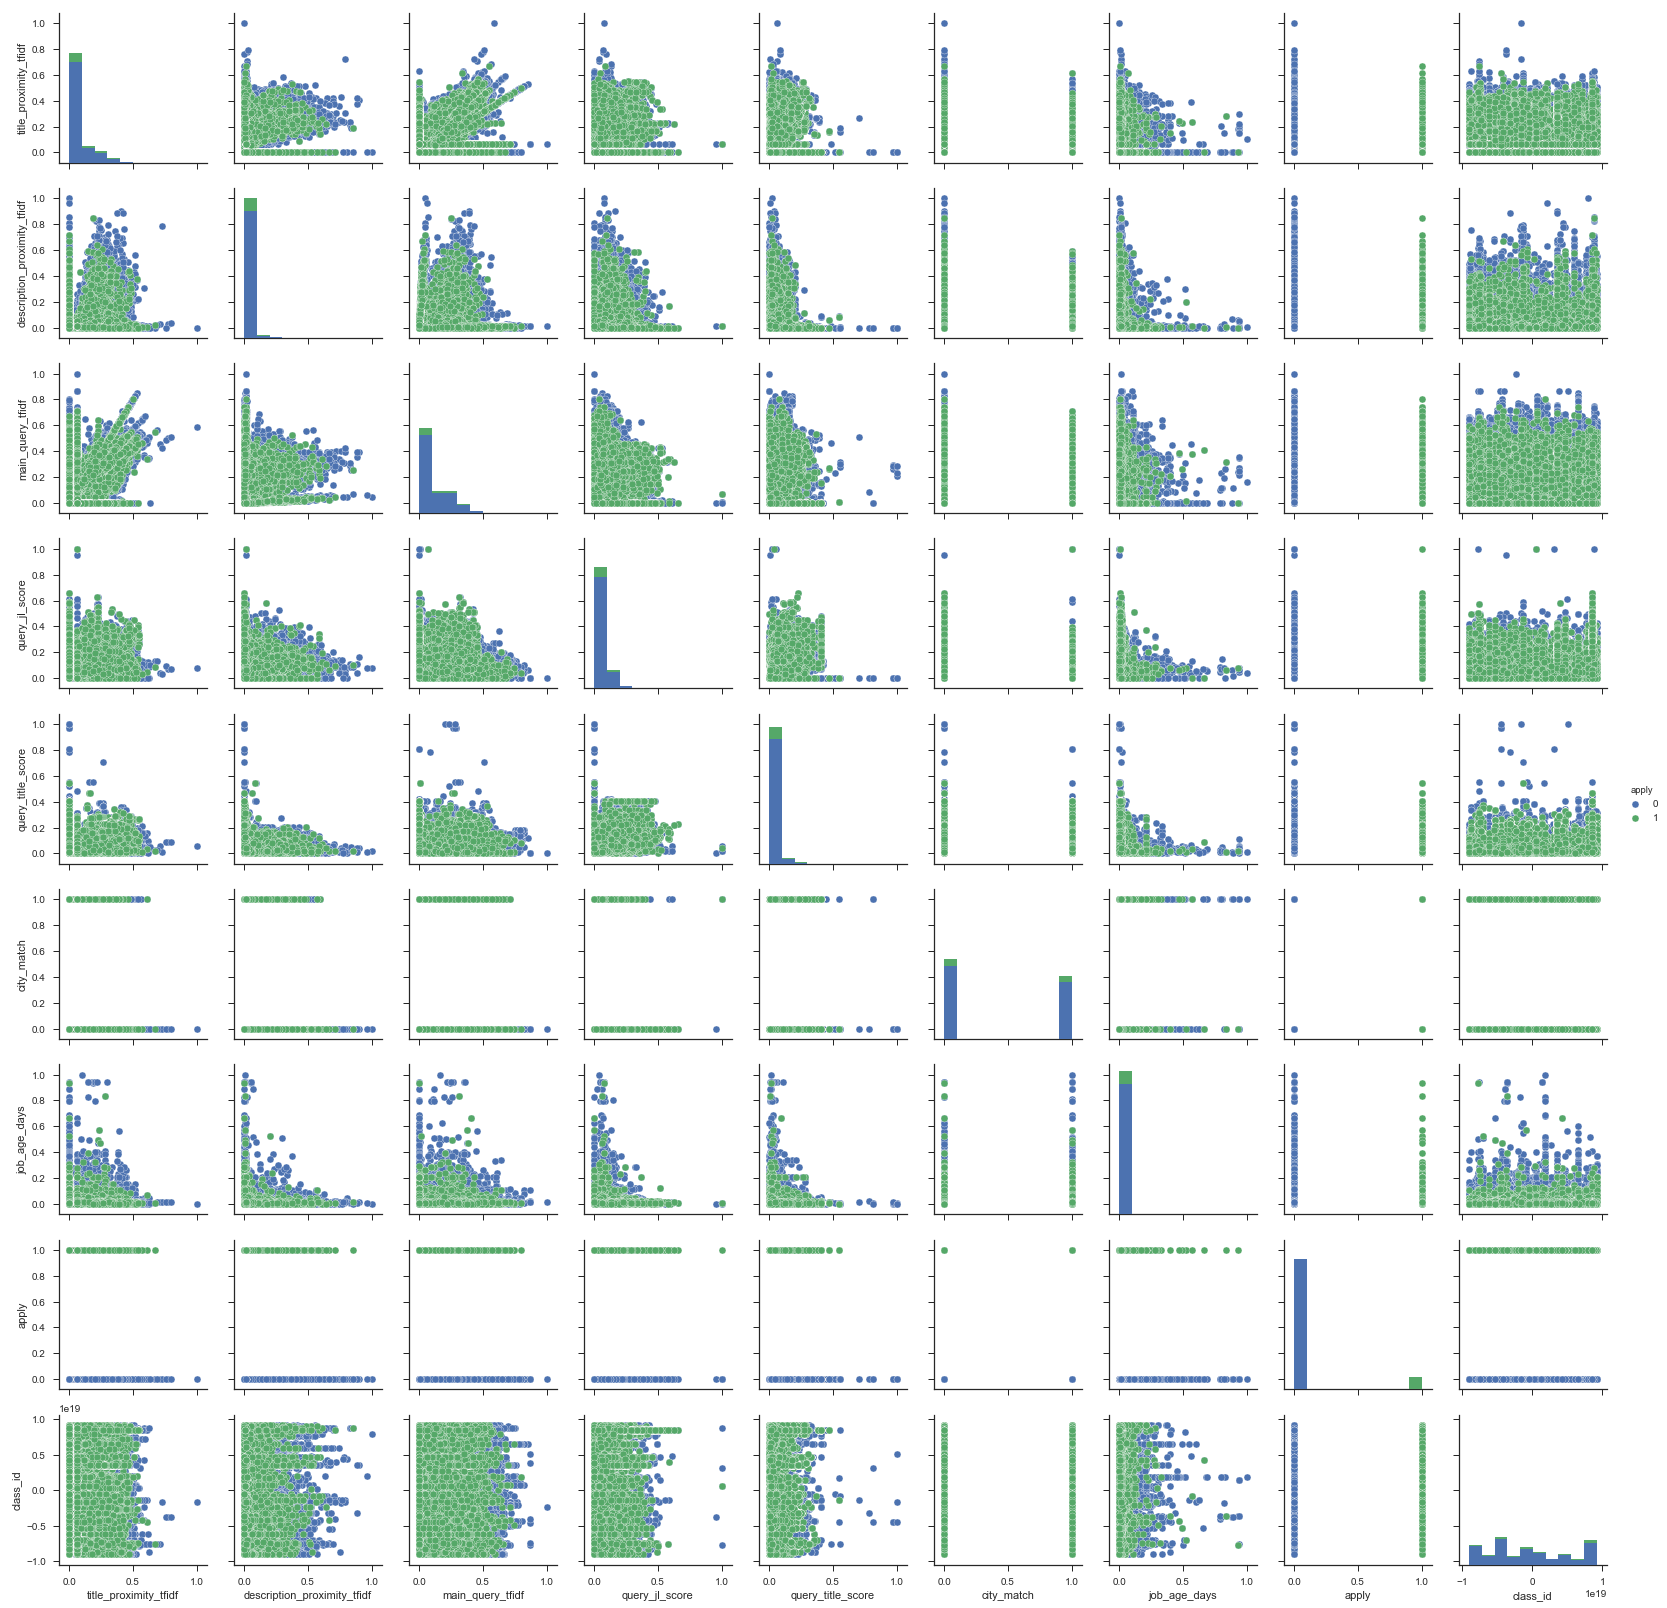

In [117]:
plt.figure(num=None, figsize=(60,60), dpi=80, facecolor='w', edgecolor='k')
sb.set(style="ticks", color_codes=True)
g = sb.pairplot(df_train,hue='apply')
plt.show()

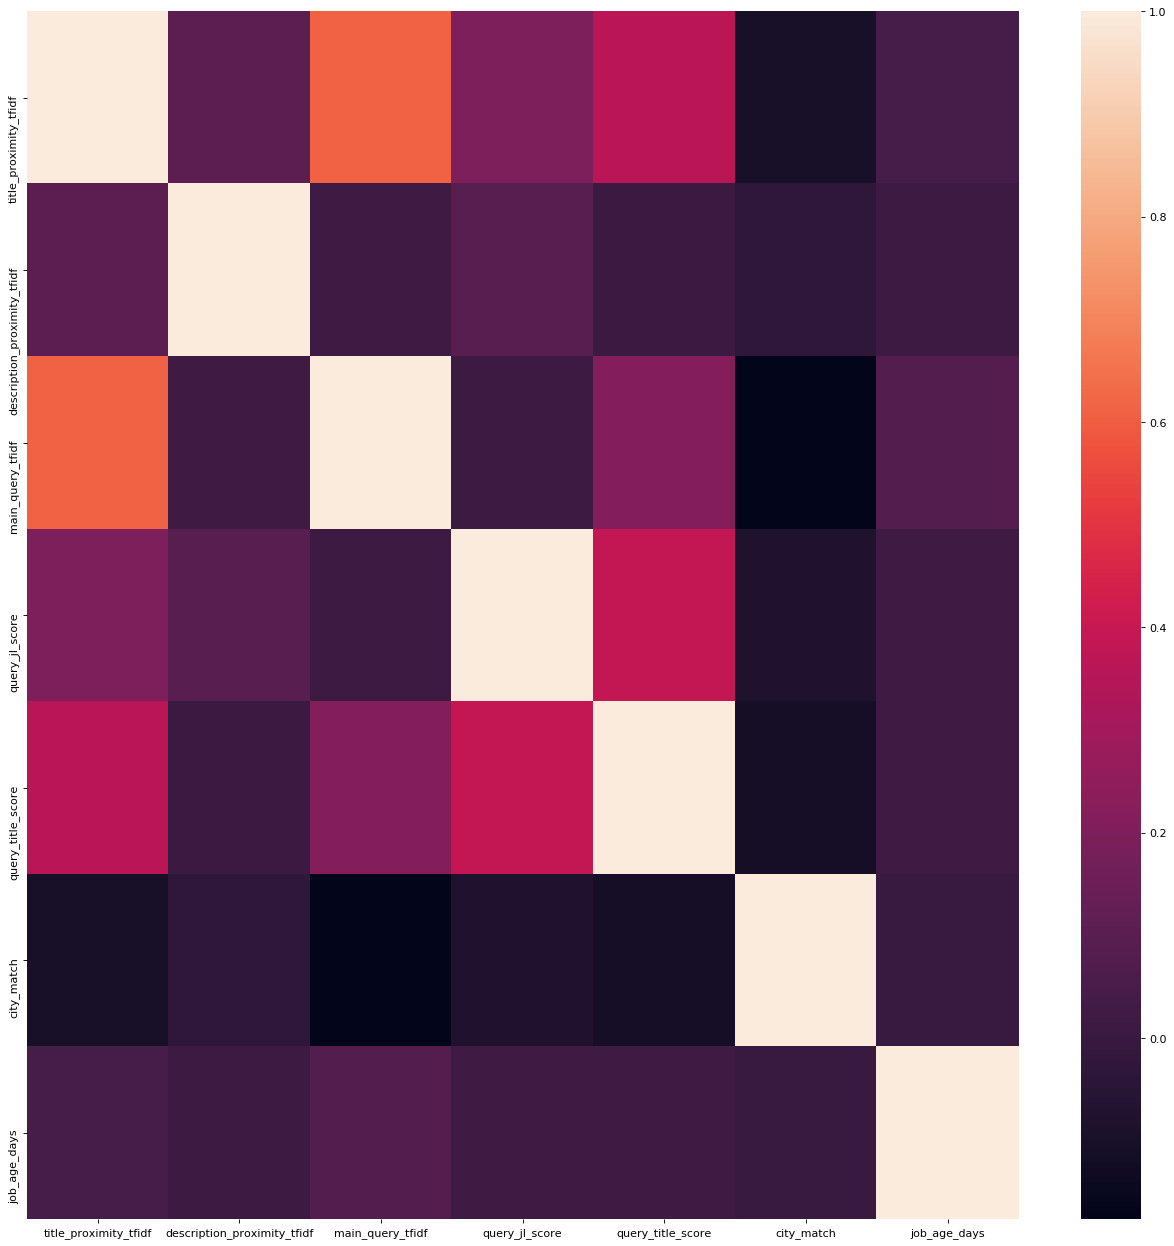

In [16]:
corr = df_train.corr()
plt.figure(num=None, figsize=(20,20), dpi=80, facecolor='w', edgecolor='k')
sb.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

We observe little linearity or correlation between features except main query tfidf and title proximity tfidf

### Create Polynomial Features

In [17]:
#Numerical columns
num_columns=['title_proximity_tfidf', 'description_proximity_tfidf','main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days',]

In [18]:
# Take into account interactions by creating polynomial features of degree 2
poly = PolynomialFeatures(2)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
# Create Training features
poly_train=poly.fit_transform(df_train[num_columns])
poly_columns=poly.get_feature_names(df_train[num_columns].columns)[7:]
poly_train=pd.DataFrame(poly_train[:,7:],columns=poly_columns)
# Create Testing features
poly_test=poly.fit_transform(df_test[num_columns])
poly_test=pd.DataFrame(poly_test[:,7:],columns=poly_columns)

In [19]:
df_train=pd.concat([df_train,poly_train], axis=1)
df_test=pd.concat([df_test,poly_test], axis=1)

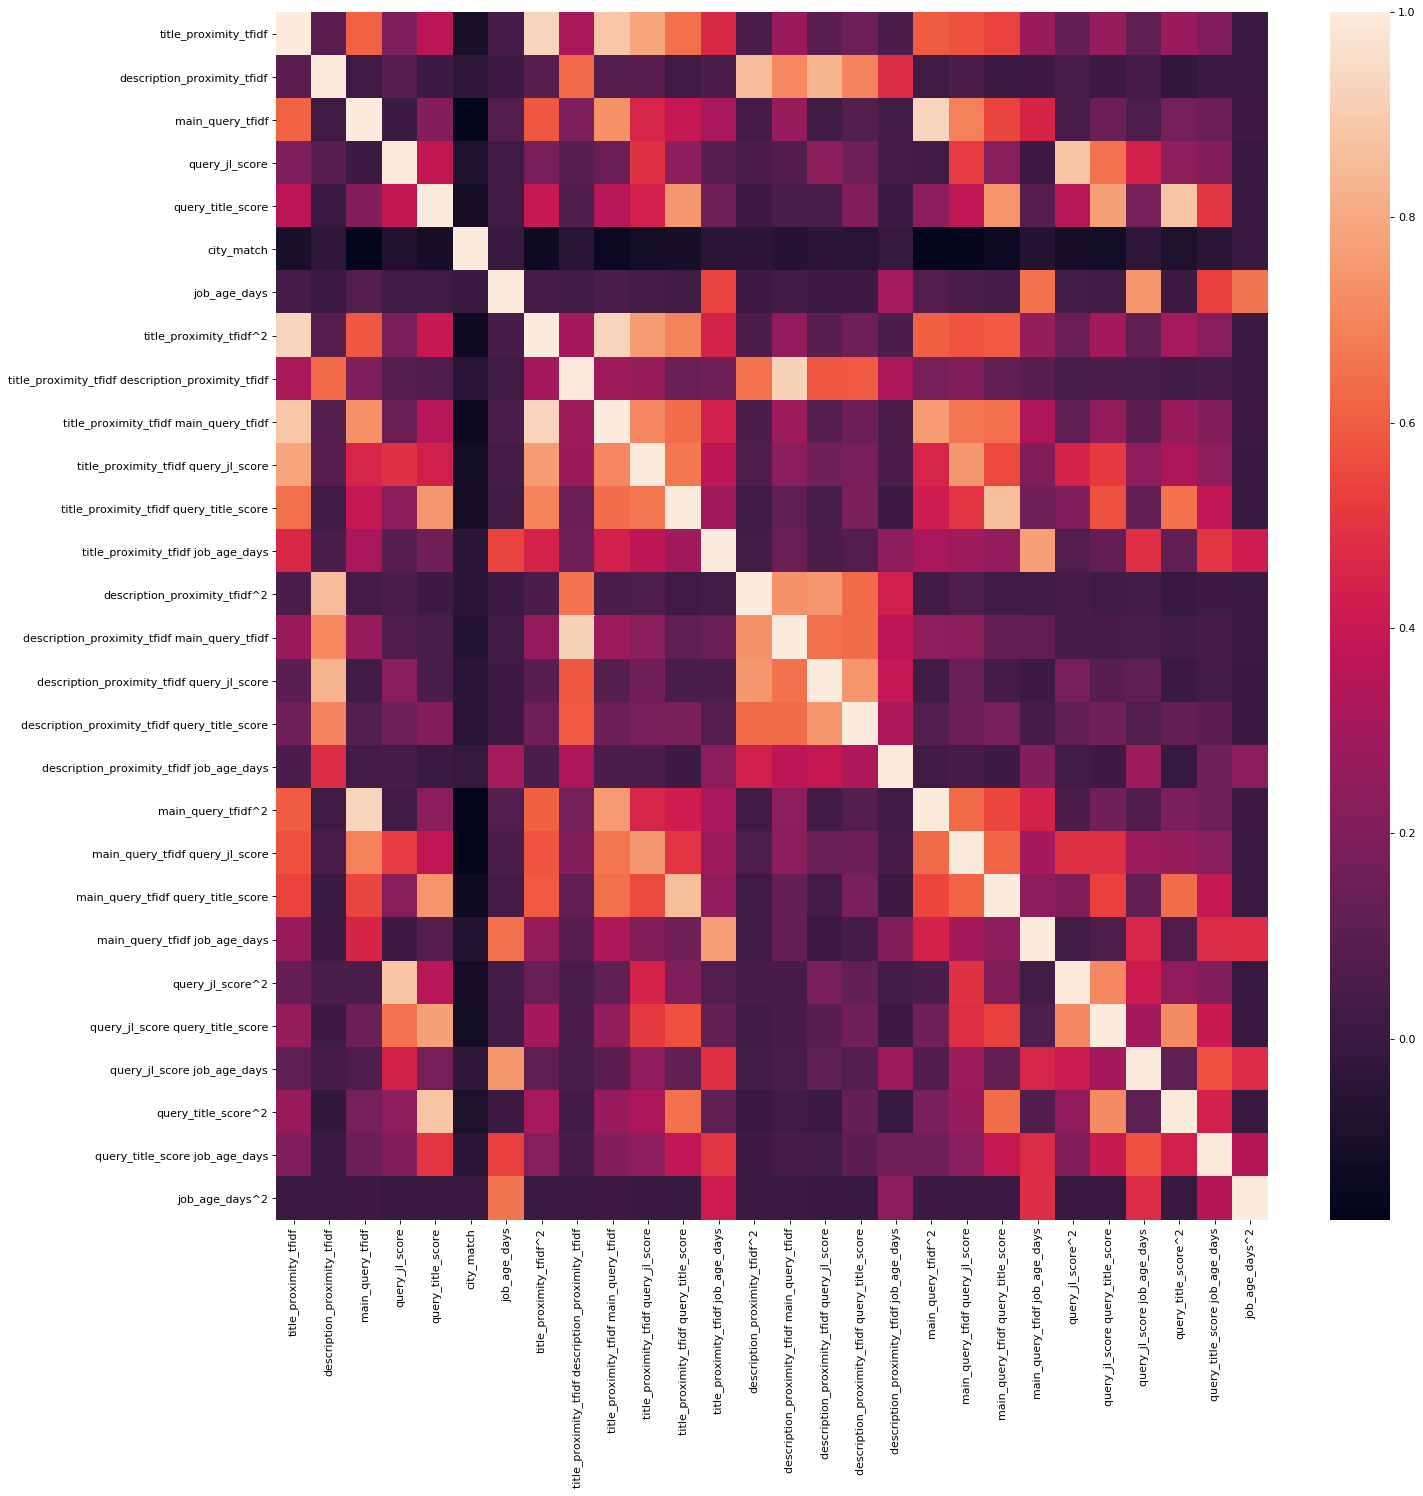

In [20]:
corr = df_train.corr()
plt.figure(num=None, figsize=(20,20), dpi=80, facecolor='w', edgecolor='k')
sb.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [21]:
df.columns[-3:]

Index(['apply', 'search_date_pacific', 'class_id'], dtype='object')

In [22]:
X,y=df_train.drop(df.columns[-3:], axis=1),df_train[df.columns[-3]]

X_cls=pd.concat([X, df_train[df.columns[-1]]], axis=1)

X_test,y_test=df_test.drop(df.columns[-3:],axis=1), df_test[df.columns[-3]]

X_test_cls=pd.concat([X_test,df_test[df.columns[-1]]], axis=1)

### Train Classifiers
- Lostic Regression
- Support Vector Machine
- RandomForest

In [25]:
clf = LogisticRegression(C=100,class_weight ='balanced')
clf.fit(X,y)

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [26]:
clf_2 = GaussianNB()
clf_2.fit(X,y)

GaussianNB(priors=None)

In [27]:
clf_3 = RandomForestClassifier(class_weight='balanced')
clf_3.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Same Classifiers with Class Id

In [64]:
clf_cls = LogisticRegression(class_weight ='balanced')
clf_cls.fit(X_cls,y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [29]:
clf_2_cls = GaussianNB()
clf_2_cls.fit(X_cls,y)

GaussianNB(priors=None)

In [30]:
clf_3_cls = RandomForestClassifier(class_weight='balanced')
clf_3_cls.fit(X_cls,y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

## Evaluate Model

### Measures
- Confusion Matrix - See actual and predicted class distribution
- AUC ROC - area under ROC (measure of sensitivity and specitivity) 
- Precision
- Recall
- F1 Score - Harmonic Mean of Precision and Recall

In [31]:
def Plot_Confusion(actual,predicted,thresh):
    fpr, tpr, threshold = metrics.roc_curve(actual, predicted[:,1])
    f1 = [] 
    for i in range(len(fpr)):
        f1.append(float(np.abs(tpr[i]-fpr[i])))
    #Using the max ROC AUC score to get the optimal probability threshold
    if thresh:
        T=thresh
    else:
        T = threshold[np.argmax(f1)]
    cm = confusion_matrix(actual,np.where(predicted[:,1]>=T,1,0)) 
    sb.heatmap(cm,annot=True,cmap='YlGnBu',fmt='d') 
    plt.xlabel('Predicted') 
    plt.ylabel('Actual')
    print("AUC ROC : {}".format(metrics.auc(fpr, tpr)))
    print("F1: {}".format(f1_score(actual,np.where(predicted[:,1]>=T,1,0)))) 
    print("Recall: {}".format(recall_score(actual,np.where(predicted[:,1]>=T,1,0)))) 
    print("Precision: {}".format(precision_score(actual,np.where(predicted[:,1]>=T,1,0)))) 
    print("Threshold Probability: {}".format(np.round(T ,2)))

AUC ROC : 0.5993326507602286
F1: 0.19713845673087654
Recall: 0.4496487119437939
Precision: 0.12624356775300172
Threshold Probability: 0.51


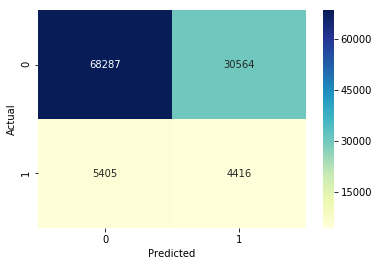

In [65]:
actual = y_test
predicted = clf.predict_proba(X_test)  
Plot_Confusion(actual,predicted,None)
plt.show()

AUC ROC : 0.5769249598361705
F1: 0.1869997106760536
Recall: 0.3948681397006415
Precision: 0.1225082925288264
Threshold Probability: 0.0


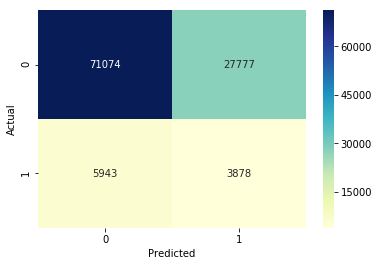

In [66]:
actual = y_test 
predicted = clf_2.predict_proba(X_test)  
Plot_Confusion(actual,predicted,None)
plt.show()

AUC ROC : 0.5439027822409349
F1: 0.17067849744257246
Recall: 0.47398431931575197
Precision: 0.10407816482582838
Threshold Probability: 0.09


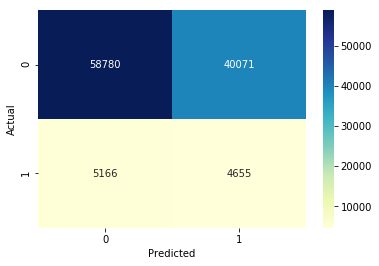

In [67]:
actual = y_test 
predicted = clf_3.predict_proba(X_test)  
Plot_Confusion(actual,predicted,None)
plt.show()

AUC ROC : 0.5125417747814662
F1: 0.1431055900621118
Recall: 0.17594949597800633
Precision: 0.12059459836694815
Threshold Probability: 0.52


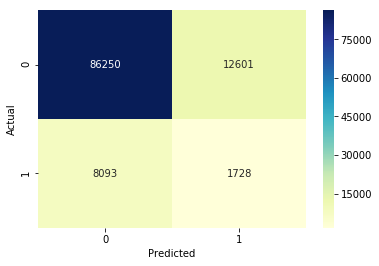

In [68]:
actual = y_test
predicted = clf_cls.predict_proba(X_test_cls)  
Plot_Confusion(actual,predicted,None)
plt.show()

AUC ROC : 0.5112271925820612
F1: 0.1431055900621118
Recall: 0.17594949597800633
Precision: 0.12059459836694815
Threshold Probability: 0.1


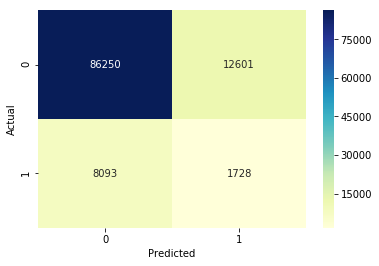

In [69]:
actual = y_test
predicted = clf_2_cls.predict_proba(X_test_cls)  
Plot_Confusion(actual,predicted,None)
plt.show()

AUC ROC : 0.5477734660506938
F1: 0.16688929476869394
Recall: 0.3116790550860401
Precision: 0.11395279577097758
Threshold Probability: 0.16


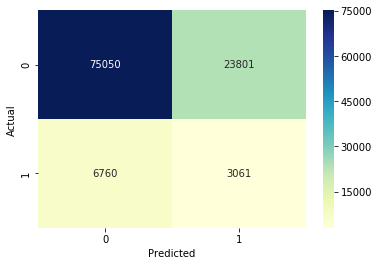

In [70]:
actual = y_test
predicted = clf_3_cls.predict_proba(X_test_cls)  
Plot_Confusion(actual,predicted,None)
plt.show()

### AUC and ROC CURVE for the best model

In [38]:
def Plot_ROC(y_test, y_score):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

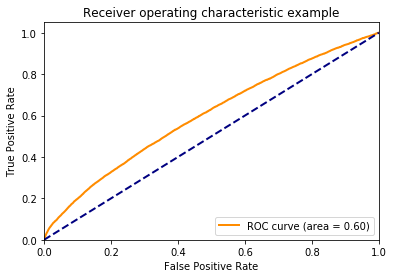

In [39]:
y_score = clf.decision_function(X_test)
Plot_ROC(y_test,y_score)

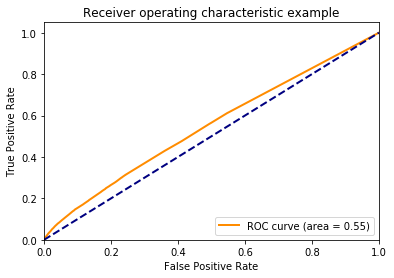

In [71]:
y_score = clf_3_cls.predict_proba(X_test_cls)[:,1]
Plot_ROC(y_test,y_score)

## Conclusion and comparison

Classic **Logistic Classifier** gives an AUC of **0.60** which is better than Naive Bayes and Random Forest.

**class_id** increases AUC and is helpful in segmentation in model like Random Forest and may give better results with other models with non linear kernel.

** Future improvement: **

- Majority undersampling or minority oversampling
- Cross validate and tune parameters
- Feature selection and regularization